# Notebook Description
This notebook is built using Jupyter notebook, running in a docker container from https://github.com/canwaf/lachesis. The sole purpose is to visualise the UK's COVID-19 vaccine rollout.

## License
This notebook is provided under license of the parent repo, the data accessed and visualised is under OLG v3.0. https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from matplotlib import gridspec
import numpy as np
import seaborn as sns
import json
import requests

In [2]:
from cachecontrol import CacheControl
from cachecontrol.caches.file_cache import FileCache
from cachecontrol.heuristics import ExpiresAfter

# Population Information
First we collect the population tables for the countries of the United Kingdom by age, and shape it accordingly. [UK's population estimates (mid-year)](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2019estimates) are from the ONS and licensed under [Open Government License v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

In [3]:
# Object manages the session
sess = requests.session()
cached_sess = CacheControl(sess, cache=FileCache('.cache'), heuristic=ExpiresAfter(weeks=12))

In [4]:
# UK Population estimates (mid-year) by age
url = 'https://www.ons.gov.uk/visualisations/dvc845/poppyramids/pyramids/datadownload.xlsx'
response = cached_sess.get(url)
data = pd.ExcelFile(response.content)
pop = data.parse('2019', skiprows=[0])


In [5]:
pop

,variable,geogcode,geogname,m_19_0,m_19_1,m_19_2,m_19_3,m_19_4,m_19_5,m_19_6,...,f_19_82,f_19_83,f_19_84,f_19_85,f_19_86,f_19_87,f_19_88,f_19_89,f_19_90,f_19_al
0,Hartlepool,E06000001,Hartlepool,515.0,532.0,515.0,583.0,533.0,577.0,600.0,...,326.0,255.0,271.0,227.0,220.0,197.0,178.0,136.0,575.0,47830.0
1,Middlesbrough,E06000002,Middlesbrough,954.0,962.0,1010.0,1003.0,1009.0,1034.0,999.0,...,382.0,361.0,334.0,288.0,286.0,219.0,218.0,186.0,662.0,71261.0
2,Redcar and Cleveland,E06000003,Redcar and Cleveland,670.0,692.0,762.0,725.0,754.0,820.0,866.0,...,525.0,442.0,405.0,362.0,305.0,295.0,262.0,236.0,898.0,70571.0
3,Stockton-on-Tees,E06000004,Stockton-on-Tees,1089.0,1093.0,1183.0,1228.0,1292.0,1302.0,1340.0,...,560.0,529.0,489.0,432.0,407.0,391.0,360.0,295.0,1004.0,99755.0
4,Darlington,E06000005,Darlington,582.0,585.0,542.0,632.0,629.0,675.0,689.0,...,361.0,343.0,327.0,253.0,263.0,226.0,190.0,170.0,719.0,54738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,ENGLAND AND WALES,K04000001,ENGLAND AND WALES,333765.0,347033.0,358209.0,369596.0,369309.0,372325.0,380825.0,...,171612.0,159775.0,147538.0,132916.0,121951.0,113232.0,102766.0,90545.0,371864.0,30057331.0
426,GREAT BRITAIN,K03000001,GREAT BRITAIN,359903.0,374092.0,386254.0,398863.0,398782.0,402075.0,411028.0,...,188277.0,175330.0,161761.0,145781.0,133356.0,123849.0,111979.0,98392.0,402111.0,32857628.0
427,UNITED KINGDOM,K02000001,UNITED KINGDOM,371576.0,386072.0,398693.0,411883.0,411576.0,414890.0,423939.0,...,193241.0,179876.0,165978.0,149501.0,136897.0,126965.0,114758.0,100820.0,411765.0,33818578.0
428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fixing the population dataframe
I can clear out the rows which aren't data at the bottom, and then combine the header columns as we're not interested in sex, only national populations and age groups
### Header format
The header format follows a pattern like `f_19_64` which accounts for females aged 64 at the mid-year 2019 estimate. As such, `sex (char(1)) underscore year of measure (char(2)) underscore age (char(2))`. As age 90 is greater than age 89, I assume age 90 includes all ages 90 and above.

In [6]:
# From above, we remove the last two rows as this does not contain data
pop = pop[:-2]


In [7]:
# Loop for all the age groups 0 through 90, create total column, drop male/female columns
for age in range(0,91):
    pop['t_19_'+str(age)] = pop['f_19_'+str(age)] + pop['m_19_'+str(age)]
    pop.drop(labels=['f_19_'+str(age), 'm_19_'+str(age)], axis=1, inplace=True)



In [8]:
pop.head()

,variable,geogcode,geogname,m_19_al,f_19_al,t_19_0,t_19_1,t_19_2,t_19_3,t_19_4,...,t_19_81,t_19_82,t_19_83,t_19_84,t_19_85,t_19_86,t_19_87,t_19_88,t_19_89,t_19_90
0,Hartlepool,E06000001,Hartlepool,45833.0,47830.0,1006.0,1009.0,1031.0,1125.0,1058.0,...,598.0,544.0,461.0,462.0,384.0,373.0,317.0,252.0,230.0,830.0
1,Middlesbrough,E06000002,Middlesbrough,69719.0,71261.0,1802.0,1944.0,1979.0,1886.0,1972.0,...,769.0,675.0,627.0,574.0,484.0,476.0,347.0,374.0,279.0,925.0
2,Redcar and Cleveland,E06000003,Redcar and Cleveland,66579.0,70571.0,1313.0,1372.0,1508.0,1421.0,1492.0,...,956.0,919.0,787.0,705.0,603.0,531.0,487.0,423.0,393.0,1321.0
3,Stockton-on-Tees,E06000004,Stockton-on-Tees,97593.0,99755.0,2149.0,2131.0,2337.0,2366.0,2479.0,...,1093.0,992.0,918.0,864.0,692.0,681.0,664.0,569.0,463.0,1491.0
4,Darlington,E06000005,Darlington,52065.0,54738.0,1100.0,1152.0,1112.0,1218.0,1208.0,...,698.0,625.0,588.0,572.0,449.0,447.0,379.0,304.0,263.0,1064.0


## Definitions
### Adult
The definition of adult may vary according to vaccine. So we'll stick with the highest common value. This is 18 or older.

#### Pfizer/BioNTech 
Not recommended for those younger than 16. [source](https://www.gov.uk/government/publications/regulatory-approval-of-pfizer-biontech-vaccine-for-covid-19/information-for-uk-recipients-on-pfizerbiontech-covid-19-vaccine)

#### Astrazeneca
Efficacy and safety not tested on those younger than 18. [source](https://www.gov.uk/government/publications/regulatory-approval-of-covid-19-vaccine-astrazeneca/information-for-healthcare-professionals-on-covid-19-vaccine-astrazeneca)

#### Moderna
Efficacy and safety not established on those younger than 18. [source](https://www.gov.uk/government/publications/regulatory-approval-of-covid-19-vaccine-moderna/information-for-healthcare-professionals-on-covid-19-vaccine-moderna)

### Minor
Not an adult. This is 17 or younger.


In [9]:
# Use list comphrenesions to generate the column names we're going to be using
minors_colnms = ['t_19_'+str(age) for age in range(0,18)]
adults_colnms = ['t_19_'+str(age) for age in range(18,91)]

In [10]:
# Aggregate on both these columns, convert to integers
pop['t_19_minors'] = pop[minors_colnms].sum(axis=1).astype(int)
pop['t_19_adults'] = pop[adults_colnms].sum(axis=1).astype(int)

# Vaccinations
Using the data from the Coronavirus dashboard at https://coronavirus.data.gov.uk, which is licensed under the [Open Government License v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

In [11]:
rename = {'newPeopleVaccinatedSecondDoseByPublishDate': 'newSecondDose',
          'newPeopleVaccinatedFirstDoseByPublishDate': 'newFirstDose',
          'cumPeopleVaccinatedFirstDoseByPublishDate': 'cumFirstDose',
          'cumPeopleVaccinatedSecondDoseByPublishDate': 'cumSecondDose',
          'weeklyPeopleVaccinatedFirstDoseByVaccinationDate': 'newFirstDose',
          'weeklyPeopleVaccinatedSecondDoseByVaccinationDate': 'newSecondDose',
          'cumPeopleVaccinatedFirstDoseByVaccinationDate': 'cumFirstDose',
          'cumPeopleVaccinatedSecondDoseByVaccinationDate': 'cumSecondDose',
          't_19_adults': 'popMid2019adults'}

## For weekly vaccinations by nation

In [12]:
# Coronavirus dashboard vaccination data
# https://coronavirus.data.gov.uk/details/healthcare#card-people_who_have_received_vaccinations_by_nation
json = requests.get('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22weeklyPeopleVaccinatedFirstDoseByVaccinationDate%22:%22weeklyPeopleVaccinatedFirstDoseByVaccinationDate%22,%22cumPeopleVaccinatedFirstDoseByVaccinationDate%22:%22cumPeopleVaccinatedFirstDoseByVaccinationDate%22,%22weeklyPeopleVaccinatedSecondDoseByVaccinationDate%22:%22weeklyPeopleVaccinatedSecondDoseByVaccinationDate%22,%22cumPeopleVaccinatedSecondDoseByVaccinationDate%22:%22cumPeopleVaccinatedSecondDoseByVaccinationDate%22%7D&format=json').json()
weekvac = pd.DataFrame(json['data'])
weekvac['date'] = pd.to_datetime(weekvac['date'], format='%Y-%m-%d') # Format date column
weekvac.head()

,areaType,areaName,areaCode,date,weeklyPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,weeklyPeopleVaccinatedSecondDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate
0,nation,England,E92000001,2021-01-31,2156423,8100353,8007,457783
1,nation,England,E92000001,2021-01-24,2224455,5943930,6323,449776
2,nation,England,E92000001,2021-01-17,1600544,3719475,40036,443453
3,nation,England,E92000001,2021-01-10,950214,2118931,382922,403417
4,nation,England,E92000001,2021-01-03,328368,1168717,20495,20495


In [13]:
# Bring in population data and drop duplicate column
weekdf = weekvac.merge(pop[['t_19_adults', 'geogcode']], how='inner', left_on='areaCode', right_on='geogcode')
weekdf.drop(['geogcode','areaType'], axis=1, inplace=True)
# Rename population value
weekdf = weekdf.rename(rename, axis=1)
# Labelling actuals
weekdf['Marker'], weekdf['Period'] = 'Actual', 'Week'
weekdf.head()

,areaName,areaCode,date,newFirstDose,cumFirstDose,newSecondDose,cumSecondDose,popMid2019adults,Marker,Period
0,England,E92000001,2021-01-31,2156423,8100353,8007,457783,44263393,Actual,Week
1,England,E92000001,2021-01-24,2224455,5943930,6323,449776,44263393,Actual,Week
2,England,E92000001,2021-01-17,1600544,3719475,40036,443453,44263393,Actual,Week
3,England,E92000001,2021-01-10,950214,2118931,382922,403417,44263393,Actual,Week
4,England,E92000001,2021-01-03,328368,1168717,20495,20495,44263393,Actual,Week


## For daily vaccinations by nation
What we're going to do is to download it, crop out anything which takes place before the latest weekly information, and append it to the dataframe, tweak the area charts' time axis and labels, to show more detail.


In [14]:
# Coronavirus daily dashboard vaccination data
# https://coronavirus.data.gov.uk/details/healthcare#card-people_who_have_received_vaccinations_by_nation
json = requests.get('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newPeopleVaccinatedFirstDoseByPublishDate%22:%22newPeopleVaccinatedFirstDoseByPublishDate%22,%22newPeopleVaccinatedSecondDoseByPublishDate%22:%22newPeopleVaccinatedSecondDoseByPublishDate%22,%22cumPeopleVaccinatedFirstDoseByPublishDate%22:%22cumPeopleVaccinatedFirstDoseByPublishDate%22,%22cumPeopleVaccinatedSecondDoseByPublishDate%22:%22cumPeopleVaccinatedSecondDoseByPublishDate%22%7D&format=json').json()
dayvac = pd.DataFrame(json['data'])
dayvac['date'] = pd.to_datetime(dayvac['date'], format='%Y-%m-%d') # Format date column
dayvac.head()


,areaType,areaName,areaCode,date,newPeopleVaccinatedFirstDoseByPublishDate,newPeopleVaccinatedSecondDoseByPublishDate,cumPeopleVaccinatedFirstDoseByPublishDate,cumPeopleVaccinatedSecondDoseByPublishDate
0,nation,England,E92000001,2021-02-08,252269.0,1419.0,10771998,473055
1,nation,England,E92000001,2021-02-07,229514.0,312.0,10519729,471636
2,nation,England,E92000001,2021-02-06,458318.0,601.0,10290215,471324
3,nation,England,E92000001,2021-02-05,401636.0,1941.0,9831897,470723
4,nation,England,E92000001,2021-02-04,388426.0,2611.0,9430261,468782


In [15]:
# Bring in population data and drop duplicate column
daydf = dayvac.merge(pop[['t_19_adults', 'geogcode']], how='inner', left_on='areaCode', right_on='geogcode')
daydf.drop(['geogcode','areaType'], axis=1, inplace=True)
daydf = daydf.rename(rename, axis=1)
# Labelling actuals
daydf['Marker'], daydf['Period'] = 'Actual', 'Day'
daydf.head()

,areaName,areaCode,date,newFirstDose,newSecondDose,cumFirstDose,cumSecondDose,popMid2019adults,Marker,Period
0,England,E92000001,2021-02-08,252269.0,1419.0,10771998,473055,44263393,Actual,Day
1,England,E92000001,2021-02-07,229514.0,312.0,10519729,471636,44263393,Actual,Day
2,England,E92000001,2021-02-06,458318.0,601.0,10290215,471324,44263393,Actual,Day
3,England,E92000001,2021-02-05,401636.0,1941.0,9831897,470723,44263393,Actual,Day
4,England,E92000001,2021-02-04,388426.0,2611.0,9430261,468782,44263393,Actual,Day


In [16]:
daydf.columns, weekdf.columns

(Index(['areaName', 'areaCode', 'date', 'newFirstDose', 'newSecondDose',
        'cumFirstDose', 'cumSecondDose', 'popMid2019adults', 'Marker',
        'Period'],
       dtype='object'),
 Index(['areaName', 'areaCode', 'date', 'newFirstDose', 'cumFirstDose',
        'newSecondDose', 'cumSecondDose', 'popMid2019adults', 'Marker',
        'Period'],
       dtype='object'))

In [17]:
combineddf =pd.concat([daydf, weekdf])

In [18]:
combineddf.head()

,areaName,areaCode,date,newFirstDose,newSecondDose,cumFirstDose,cumSecondDose,popMid2019adults,Marker,Period
0,England,E92000001,2021-02-08,252269.0,1419.0,10771998,473055,44263393,Actual,Day
1,England,E92000001,2021-02-07,229514.0,312.0,10519729,471636,44263393,Actual,Day
2,England,E92000001,2021-02-06,458318.0,601.0,10290215,471324,44263393,Actual,Day
3,England,E92000001,2021-02-05,401636.0,1941.0,9831897,470723,44263393,Actual,Day
4,England,E92000001,2021-02-04,388426.0,2611.0,9430261,468782,44263393,Actual,Day


In [19]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def millions_formatter(x, pos):
    return f'{x / 1000000}'

formatter = FuncFormatter(millions_formatter)

# Plots

In [20]:
vulnerable = 12000000
population = pop.loc[pop['geogcode'] == 'K02000001', 't_19_adults'].values[0]

## Population information shaping
This is here so we can create a narrow area chart showing people the 'work' to do in a more transparent manner, to be joined to the side of any other chart as part of a subplot

In [21]:
nations = ['E92000001', 'N92000002', 'S92000003', 'W92000004']
natpop = pop.loc[pop['geogcode'].isin(nations), ['geogname', 't_19_adults']]
natpop['geogname']  = natpop['geogname'].str.title()
natpop.columns = ['Nation', 'pop']
natpop = natpop.set_index('Nation')
natpop['cumPop'] = natpop.cumsum()
natpop = natpop.reset_index()
natpop


,Nation,pop,cumPop
0,England,44263393,44263393
1,Northern Ireland,1452962,45716355
2,Scotland,4434138,50150493
3,Wales,2522940,52673433


In [22]:
def m_format(n, pos):
    return str(int(n/1e6))

m_formatter = FuncFormatter(m_format)

In [23]:
def shape_it(df: pd.DataFrame() = None, index: str = 'date', area: str = 'areaName', count: str = None) -> pd.DataFrame():
    
    return df[[index, area, count]].pivot(index=index, columns=area, values=count)

## First Vaccinations

In [24]:
shape_first_day = shape_it(df=combineddf[combineddf['Period'] == 'Day'], count='cumFirstDose')
shape_first_day

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2021-01-10,1959151,78005,163377,86039
2021-01-11,2080280,84187,175942,91239
2021-01-12,2254556,91417,191965,101371
2021-01-13,2494371,102701,208207,112973
2021-01-14,2769164,114567,224840,126375
2021-01-15,3090058,117906,224840,126375
2021-01-16,3365492,120387,224840,126375
2021-01-17,3520056,125717,264991,151737
2021-01-18,3687206,132857,284582,161932


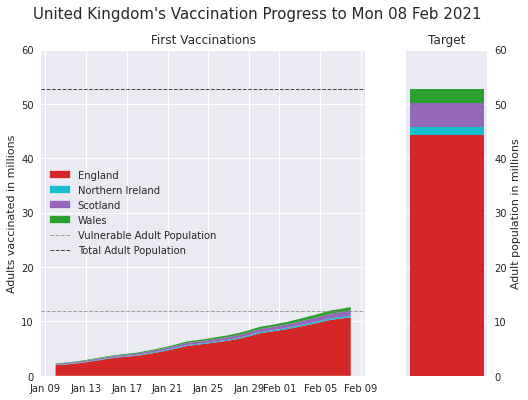

In [25]:
plt.close('all')
#define chart parameters
plt.style.use('seaborn')

# fig, (a0, a1) = plt.subplots(nrows=1, ncols=2,squeeze=False)

fig = plt.figure(figsize=(8,6))

gs = gridspec.GridSpec(1,2, width_ratios=[4,1])

a0 = plt.subplot(gs[0])
a1 = plt.subplot(gs[1])

nat_col = [('Wales', 'tab:green'), ('Scotland','tab:purple'), ('Northern Ireland','tab:cyan'), ('England', 'tab:red')]

# Vaccination area chart
a0.stackplot(shape_first_day.index, [shape_first_day[x] for x in shape_first_day.columns], colors=reversed([x[1] for x in nat_col]))
vulnline = a0.axhline(vulnerable, c='grey', ls='dashed', lw=1, alpha=0.7, label='Vulnerable Adult Population')
popline = a0.axhline(population, c='black', ls='dashed', lw=1, alpha=0.7, label='Total Adult Population')
date_form = DateFormatter("%b %d")
a0.xaxis.set_major_formatter(date_form)
a0.set_ylabel('Adults vaccinated in millions')

# Population bar chart
for nation, colour in nat_col:
    a1.bar(x = 1, height=natpop.loc[natpop['Nation']==nation, 'pop'], bottom=natpop.loc[natpop['Nation']==nation, 'cumPop']-natpop.loc[natpop['Nation']==nation, 'pop'], label=nation, color=colour)
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Adult population in millions')
a1.axes.get_xaxis().set_visible(False)

# Set common axis
for axis in [a0,a1]:
    axis.set_ylim(top=60000000)
    axis.ticklabel_format(style='plain', axis='y', useOffset=False)
    axis.yaxis.set_major_formatter(m_formatter)

# Labels
a0.title.set_text('First Vaccinations')
a1.title.set_text('Target')

# Legend
patches = [mpatches.Patch(color=color, label=nation) for nation, color in reversed(nat_col)]
[patches.append(x) for x in [vulnline, popline]]
a0.legend(loc='center left', handles=patches)

fig_title = f"United Kingdom's Vaccination Progress to {shape_first_day.index.max().strftime('%a %d %b %Y')}"

fig.suptitle(fig_title, fontsize=15)

plt.show()
fig.savefig(f"first_vaccinations_{shape_first_day.index.max().strftime('%Y%m%d')}")

## Second Vaccinations

In [26]:
shape_second_day = shape_it(df=combineddf[combineddf['Period'] == 'Day'], count='cumSecondDose')
shape_second_day

areaName,England,Northern Ireland,Scotland,Wales
date,,,,
2021-01-10,374613,13949,2758,79
2021-01-11,393925,15288,2857,97
2021-01-12,407294,17840,2990,108
2021-01-13,415656,19010,3190,121
2021-01-14,420510,19264,3331,129
2021-01-15,424327,19474,3331,129
2021-01-16,426102,20174,3331,129
2021-01-17,427386,21016,3698,201
2021-01-18,431136,21579,3886,265


In [27]:
nat_col = [('Wales', 'tab:green'), ('Scotland','tab:purple'), ('Northern Ireland','tab:cyan'), ('England', 'tab:red')]

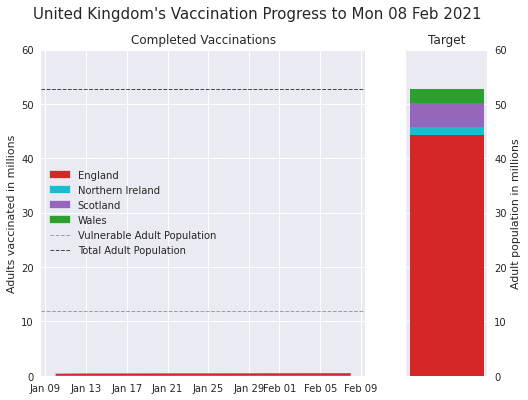

In [28]:
plt.close('all')
#define chart parameters
plt.style.use('seaborn')

fig = plt.figure(figsize=(8,6))

gs = gridspec.GridSpec(1,2, width_ratios=[4,1])

a0 = plt.subplot(gs[0])
a1 = plt.subplot(gs[1])

# Vaccination area chart
a0.stackplot(shape_second_day.index, [shape_second_day[x] for x in shape_second_day.columns], colors=reversed([x[1] for x in nat_col]))
vulnline = a0.axhline(vulnerable, c='grey', ls='dashed', lw=1, alpha=0.7, label='Vulnerable Adult Population')
popline = a0.axhline(population, c='black', ls='dashed', lw=1, alpha=0.7, label='Total Adult Population')
date_form = DateFormatter("%b %d")
a0.xaxis.set_major_formatter(date_form)
a0.set_ylabel('Adults vaccinated in millions')

# Population bar chart
for nation, colour in nat_col:
    a1.bar(x = 1, height=natpop.loc[natpop['Nation']==nation, 'pop'], bottom=natpop.loc[natpop['Nation']==nation, 'cumPop']-natpop.loc[natpop['Nation']==nation, 'pop'], label=nation, color=colour)
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Adult population in millions')
a1.axes.get_xaxis().set_visible(False)

# Set common axis
for axis in [a0,a1]:
    axis.set_ylim(top=60000000)
    axis.ticklabel_format(style='plain', axis='y', useOffset=False)
    axis.yaxis.set_major_formatter(m_formatter)

# Labels
a0.title.set_text('Completed Vaccinations')
a1.title.set_text('Target')

# Legend
patches = [mpatches.Patch(color=color, label=nation) for nation, color in reversed(nat_col)]
[patches.append(x) for x in [vulnline, popline]]
a0.legend(loc='center left', handles=patches)

fig_title = f"United Kingdom's Vaccination Progress to {shape_second_day.index.max().strftime('%a %d %b %Y')}"

fig.suptitle(fig_title, fontsize=15)

plt.show()
fig.savefig(f"completed_vaccinations_{shape_second_day.index.max().strftime('%Y%m%d')}")

# Future work, monitoring progress
* On 10 January 2021, Matt Hancock tweeted that "the country" has vaccinated a third of the over 80s. Assumption: he's talking about England. [source](https://twitter.com/MattHancock/status/1348235558783512576)
* On 10 January 2021, Matt Hancock said that every adult could have a coronavirus vaccine by Autumn. Assumption: he's talking about all of the United Kingdom. [source](https://twitter.com/PippaCrerar/status/1348203365969362944)

In [29]:
total_daily_jabs = combineddf.loc[combineddf['Period'] == 'Day']
total_daily_jabs = total_daily_jabs[['date','areaName', 'areaCode', 'newFirstDose', 'newSecondDose']]
total_daily_jabs['newDoses'] = total_daily_jabs['newFirstDose'] + total_daily_jabs['newSecondDose']
first_diff_daily_jabs = shape_it(df=total_daily_jabs, index='date', area='areaName', count='newDoses').diff()[2:]

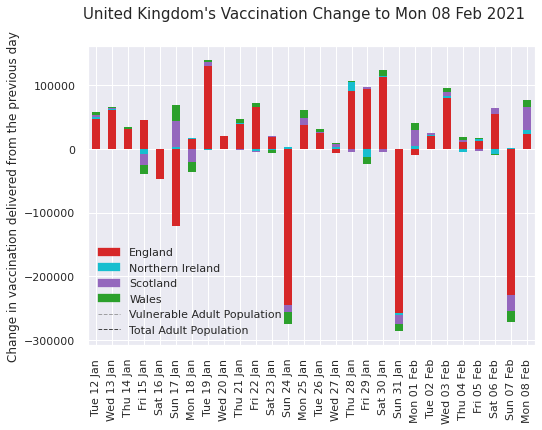

In [30]:
sns.set()

fig1 = plt.figure()

a0 = fig1.add_subplot()

first_diff_daily_jabs.plot(kind='bar', stacked=True, color=list(reversed([x[1] for x in nat_col])), ax=a0)

a0.set_xticklabels(first_diff_daily_jabs.index.strftime('%a %d %b').to_list())

a0.set_ylabel('Change in vaccination delivered from the previous day')

a0.set_xlabel(None)

for patch in a0.patches:
    patch.set_linewidth(0)

a0.legend(loc='lower left', handles=patches)

fig1.axes.append(a0)

fig_title = f"United Kingdom's Vaccination Change to {shape_second_day.index.max().strftime('%a %d %b %Y')}"

fig1.suptitle(fig_title, fontsize=15)

fig1.show()

fig1.savefig(f"vaccine_delta_{first_diff_daily_jabs.index.max().strftime('%Y%m%d')}", bbox_inches='tight')

In [31]:
combineddf.loc[(combineddf['Period'] == 'Day') & (combineddf['date'] == combineddf['date'].max())].sum()

areaName            EnglandNorthern IrelandScotlandWales
areaCode            E92000001N92000002S92000003W92000004
newFirstDose                                    352480.0
newSecondDose                                     3811.0
cumFirstDose                                    12646486
cumSecondDose                                     516392
popMid2019adults                                52673433
Marker                          ActualActualActualActual
Period                                      DayDayDayDay
dtype: object